# Objective
To verify whether petrol formulations are significantly different.

# Deliverables
1. Descriptive analysis of the additives/features. Analaysis must include summaries of findings & correlation.
2. Graphical analysis of the additives, including a distribution study.
3. Clustering of the data to determine the distinctive number of formulations.

#  Setting up the workspace

## Importing libraries

In [1]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

## Reading in the data

In [2]:
DATA = "PreScreen_r3\ingredient.csv"
ingredients = pd.read_csv(DATA)
ingredients.head()

,a,b,c,d,e,f,g,h,i
0,1.51735,13.02,3.54,1.69,72.73,0.54,8.44,0.00,0.07
1,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28
2,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.00,0.03
3,1.51768,12.56,3.52,1.43,73.15,0.57,8.54,0.00,0.00
4,1.51813,13.43,3.98,1.18,72.49,0.58,8.15,0.00,0.00


# Q1a. Descriptive analysis of the additives

In [3]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       214 non-null    float64
 1   b       214 non-null    float64
 2   c       214 non-null    float64
 3   d       214 non-null    float64
 4   e       214 non-null    float64
 5   f       214 non-null    float64
 6   g       214 non-null    float64
 7   h       214 non-null    float64
 8   i       214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


There are no missing data.

All features are continuous features.

In [4]:
ingredients.describe()

,a,b,c,d,e,f,g,h,i
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


<AxesSubplot:>

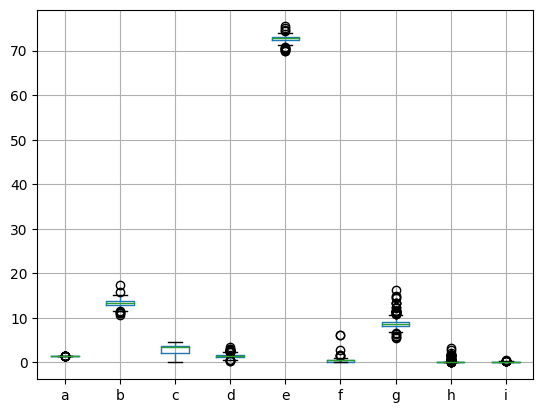

In [5]:
ingredients.boxplot()

The features are of different scales.

Features c, f, h & i have min values of 0.

h & i have a lot of zeroes and appear to have outliers (see plot below).

<AxesSubplot:>

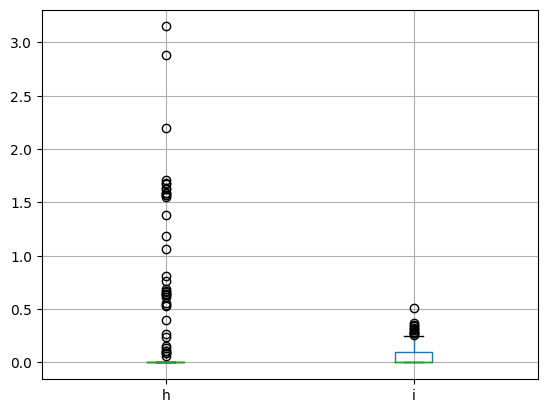

In [6]:
ingredients.boxplot(column=["h", "i"])

# Q1b. Graphical analysis of the additives

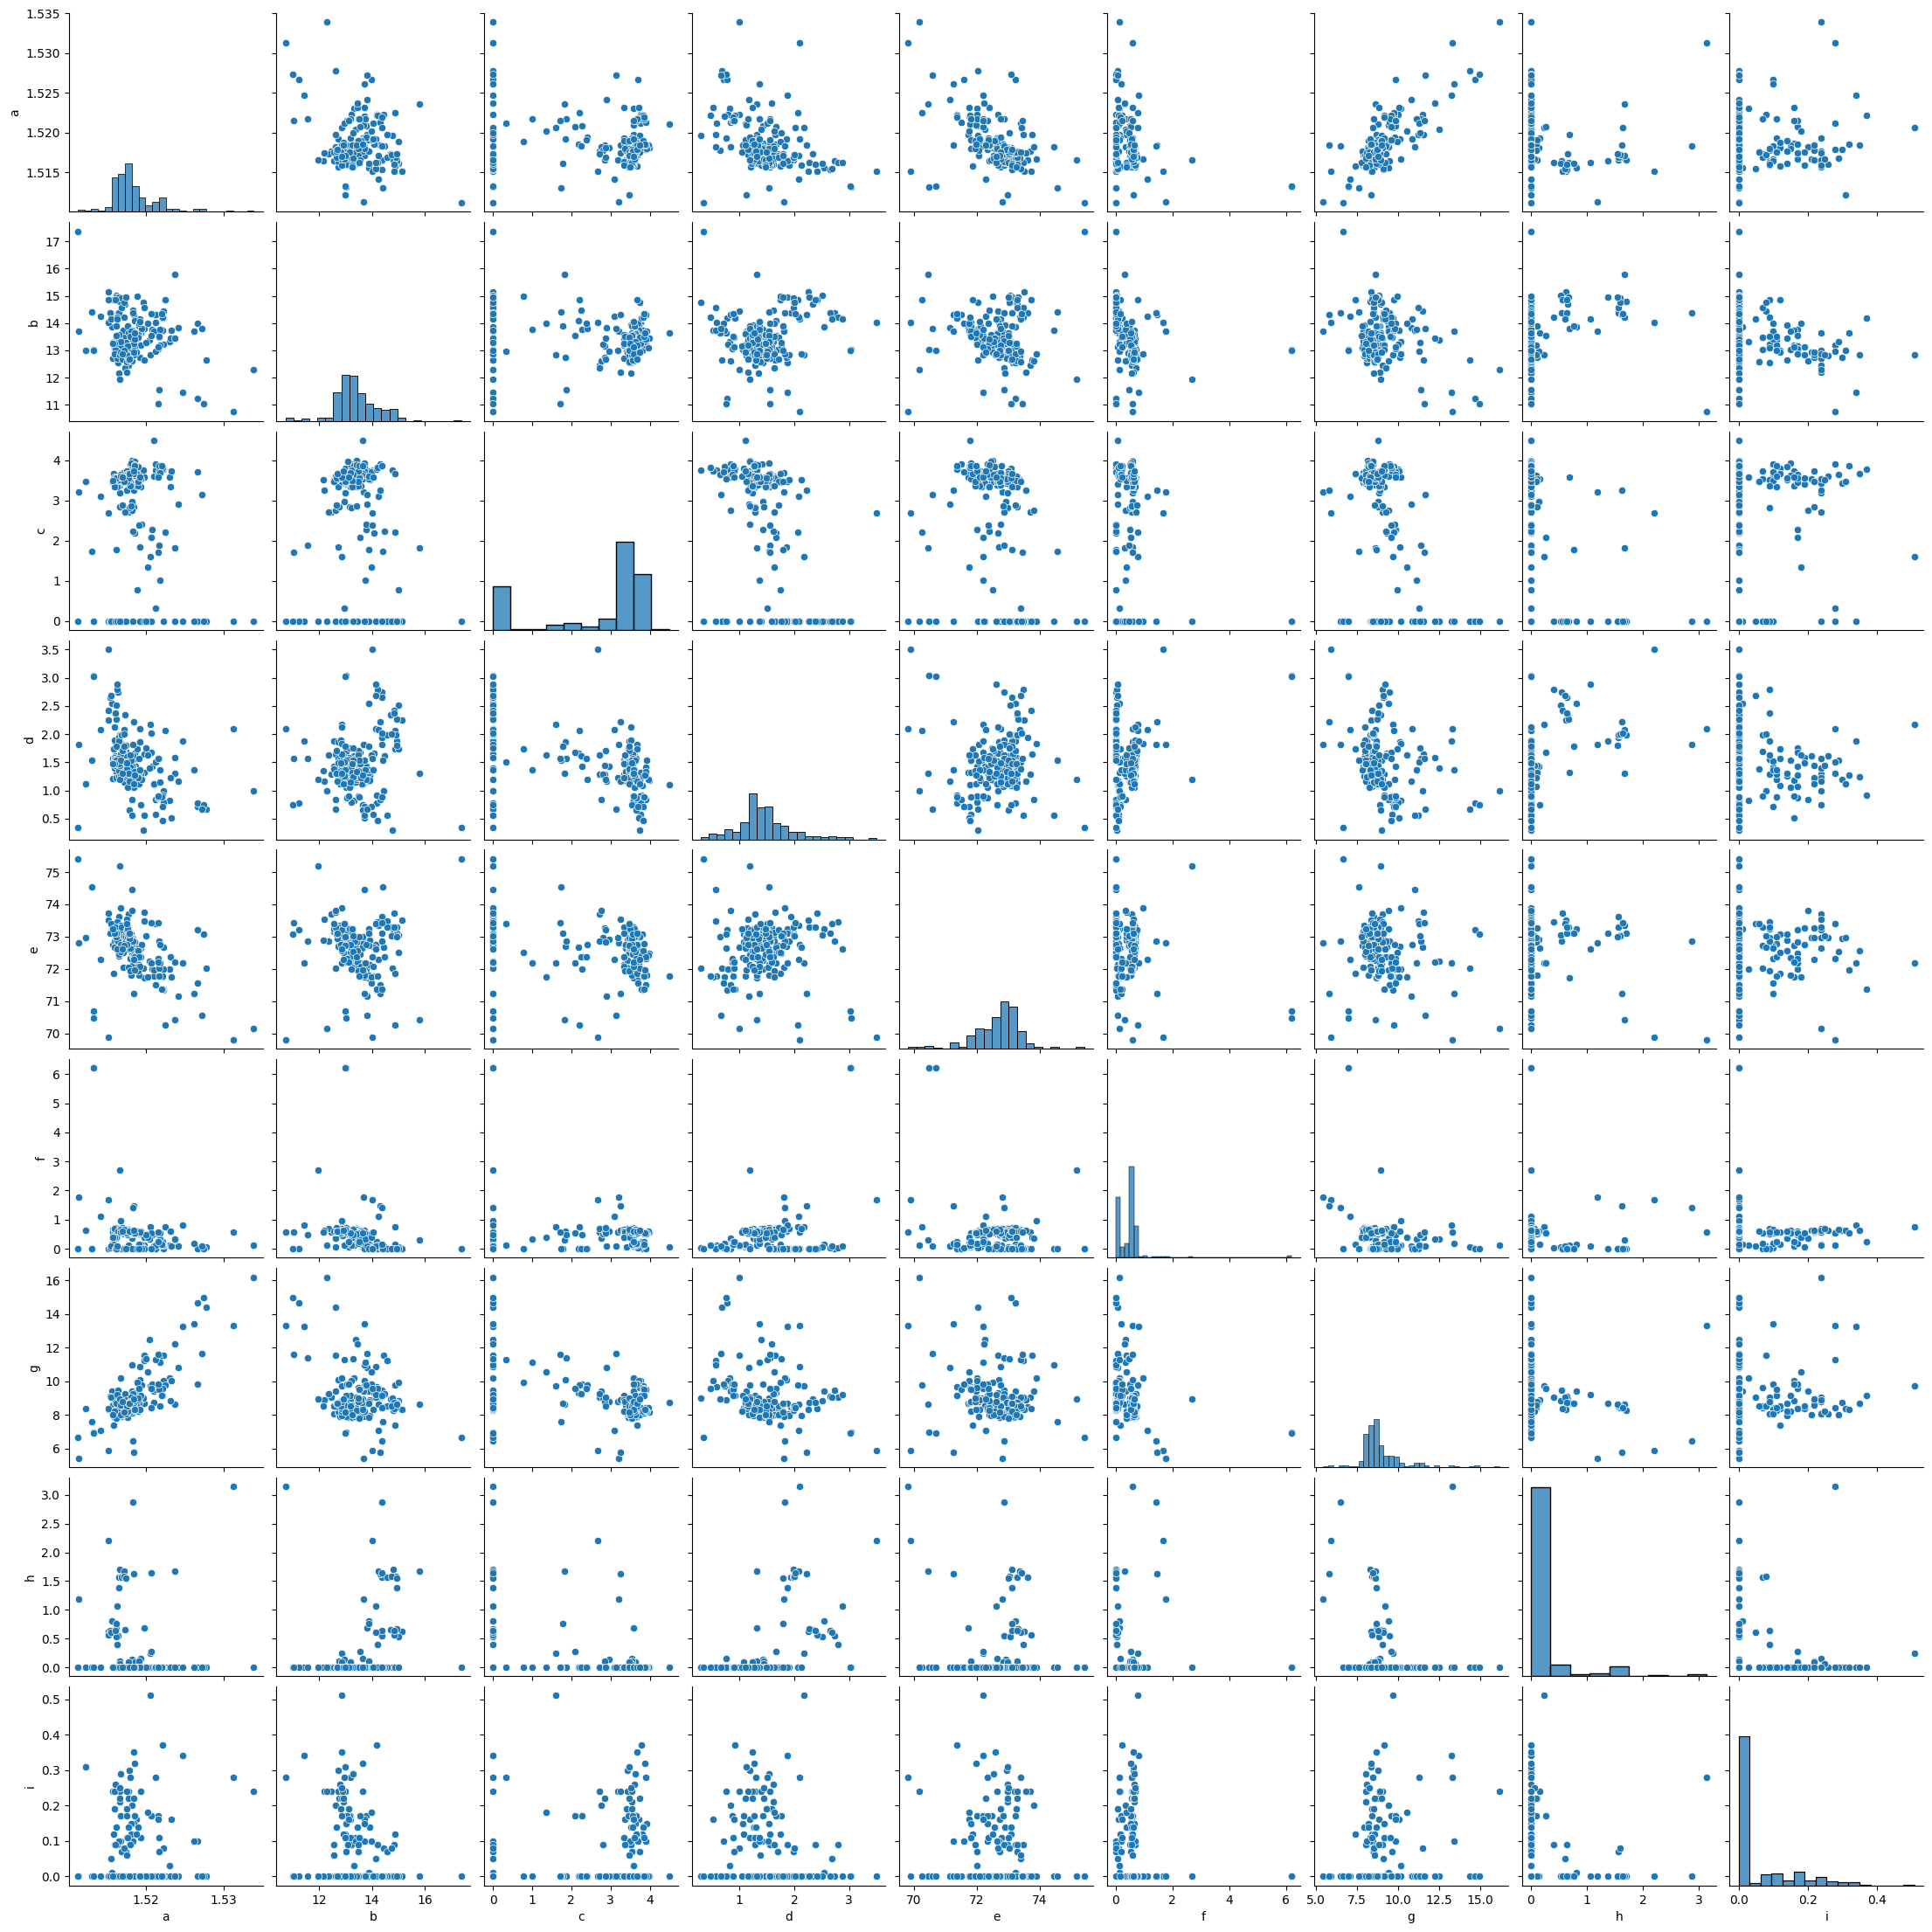

In [7]:
sns.pairplot(ingredients)

Some additives are bimodal e.g. c & f (see plots below).

None of the additives have a normal distribution.

There are outliers in many additives e.g. a, d & f.

Additives a & g have a strong, positive liner correlation. Additives a & e have a negative linear correlation (see heatmap).

Text(0.5, 1.0, 'Additive c is bimodal.')

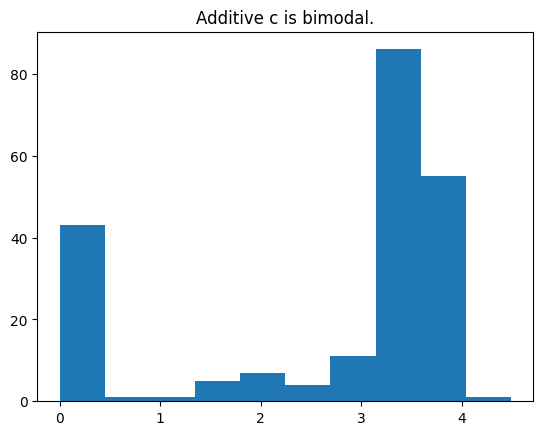

In [8]:
fig, ax = plt.subplots()
ax.hist(ingredients["c"])
ax.set_title("Additive c is bimodal.")

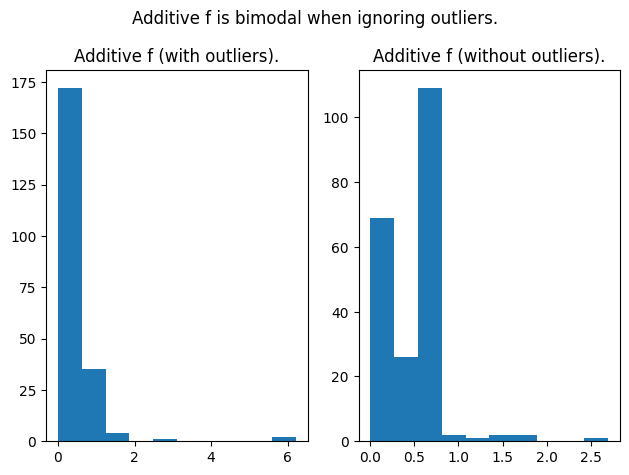

In [9]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Additive f is bimodal when ignoring outliers.")
ax[0].hist(ingredients["f"])
ax[0].set_title("Additive f (with outliers).")

ax[1].hist(ingredients.loc[ingredients["f"] < 3, "f"])
ax[1].set_title("Additive f (without outliers).")

fig.tight_layout()

<AxesSubplot:>

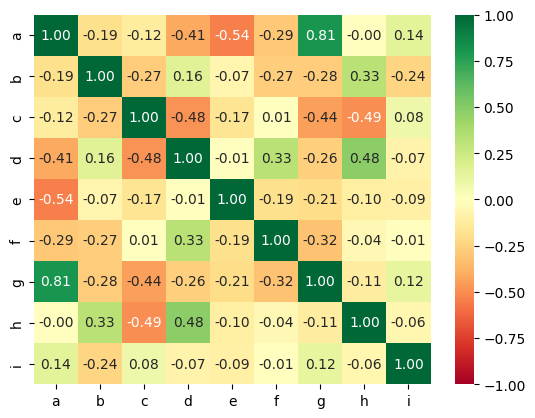

In [10]:
sns.heatmap(ingredients.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='RdYlGn')

# Summary of Findings
1. Before proceeding to clustering, the data needs to be scaled as the additives are on different scales.
2. Additives c, f, h & i are not included in all of the formulations.
3. Additives c & f are bimodal indicating the possible presence of two clusters in the data.
4. None of the additives have a normal distribution, which is expected as petrol formulations are not natural phenomena.

# Q1c. Clustering 

## Data scaling
We will use the MinMaxScaler instead of StandardScaler as the distributions of the additives are not normal.

In [11]:
scaler = MinMaxScaler()
ingredients_scaled = scaler.fit_transform(ingredients)
ingredients_scaled = pd.DataFrame(ingredients_scaled, index=ingredients.index, columns=ingredients.columns)
ingredients_scaled.head()

,a,b,c,d,e,f,g,h,i
0,0.272169,0.344361,0.788419,0.436137,0.521429,0.086957,0.279740,0.0,0.137255
1,0.882353,0.000000,0.000000,0.563863,0.000000,0.093398,0.731413,1.0,0.549020
2,0.520193,0.387970,0.797327,0.165109,0.389286,0.019324,0.440520,0.0,0.058824
3,0.286655,0.275188,0.783964,0.355140,0.596429,0.091787,0.289033,0.0,0.000000
4,0.306409,0.406015,0.886414,0.277259,0.478571,0.093398,0.252788,0.0,0.000000


## Principal Component Analysis (PCA)

PCA is conducted to reduce the number of features (considering we only 214 samples) as well as to reduce the impact of
outliers.

In [12]:
n_pcs = 4  # Determined by trial and error
pca_ingredients = PCA(n_components=n_pcs)
pca_values = pca_ingredients.fit_transform(ingredients_scaled)

In [13]:
print(f"{round(sum(pca_ingredients.explained_variance_ratio_)*100, 2)}% of the variance is explained by the {n_pcs} components.") 

85.87% of the variance is explained by the 4 components.


With only 4 features, it is easier to interpret their distributions and relationships.

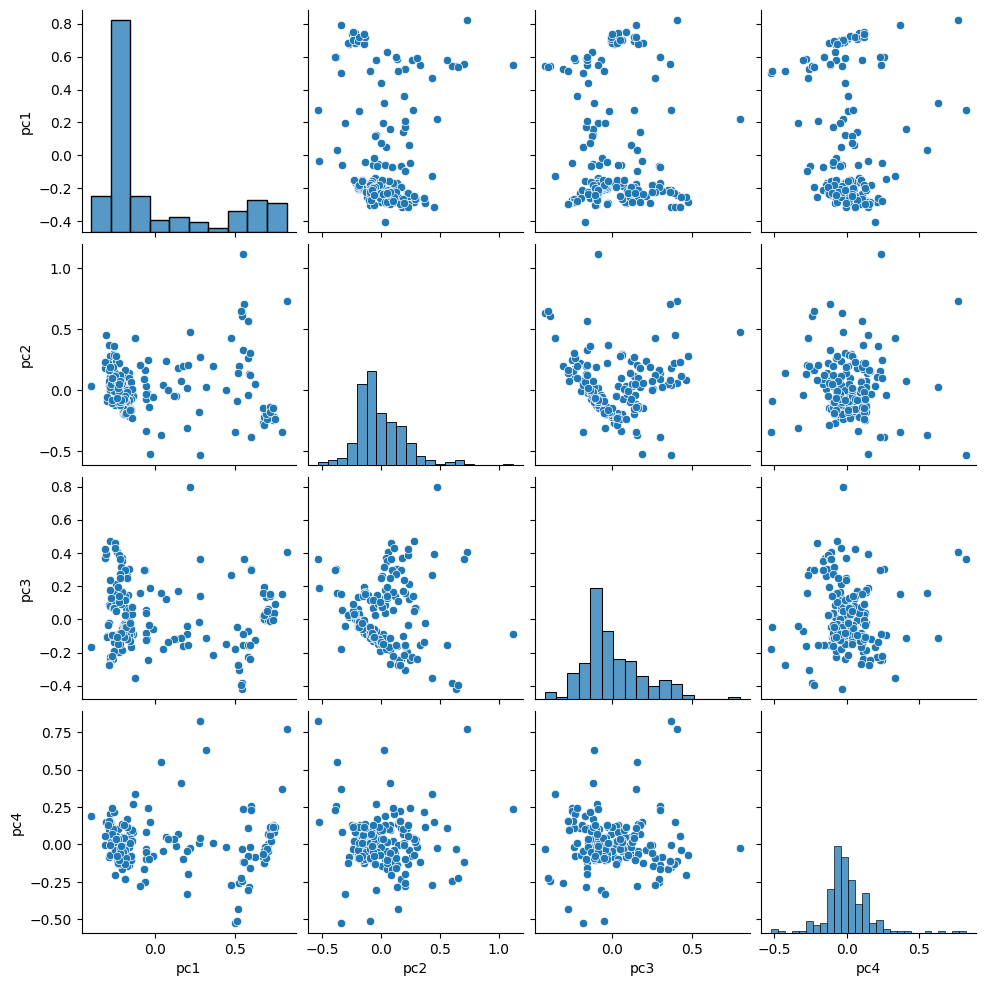

In [14]:
pca_values = pd.DataFrame(pca_values, columns=["pc1", "pc2", "pc3", "pc4"])
sns.pairplot(pca_values)

The scatterplots indicate that there could be **two or three clusters** within the data.

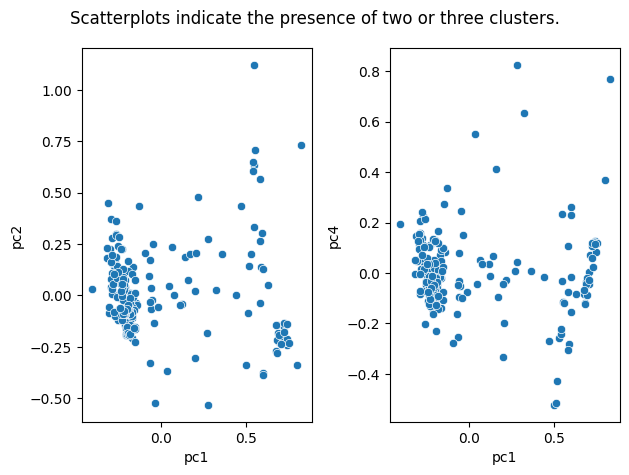

In [15]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Scatterplots indicate the presence of two or three clusters.")
sns.scatterplot(pca_values["pc1"], pca_values["pc2"], ax=ax[0])
sns.scatterplot(pca_values["pc1"], pca_values["pc4"], ax=ax[1])

fig.tight_layout()

## Clustering with K-Means

In [16]:
sse = []
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 23,
    }

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, **kmeans_kwargs)
    kmeans.fit(pca_values)
    sse.append(kmeans.inertia_)

### Determining number of clusters using elbow method

Text(0.5, 0, 'No. of clusters')

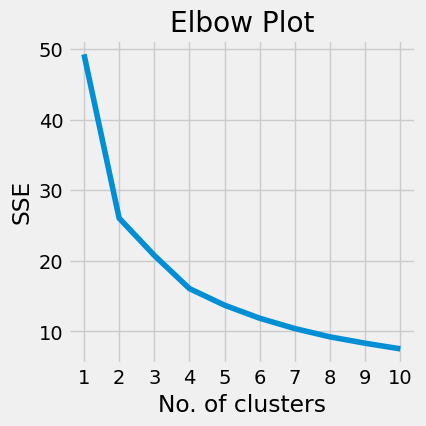

In [17]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(range(1, 11), sse)
ax.set_title("Elbow Plot")
ax.set_xticks(range(1, 11))
ax.set_ylabel("SSE")
ax.set_xlabel("No. of clusters")

In [18]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
    )

print(f"The maximum curvature occurs when the number of clusters is {kl.elbow}.")

The maximum curvature occurs when the number of clusters is 4.


### We can also identify the number of clusters using silhouette coefficients.

In [19]:
silhouette_coefficients = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, **kmeans_kwargs)
    kmeans.fit(pca_values)
    score = silhouette_score(pca_values, kmeans.labels_)
    silhouette_coefficients.append(score)

Text(0.5, 0, 'No. of Clusters')

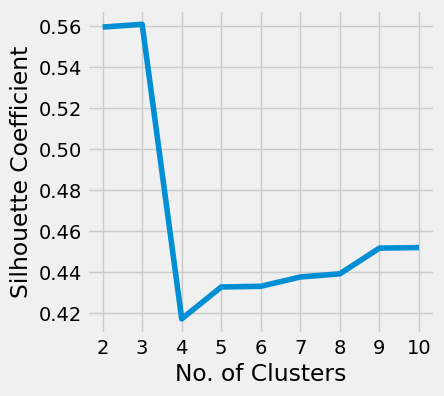

In [20]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(range(2, 11), silhouette_coefficients)
ax.set_xticks(range(2, 11))
ax.set_ylabel("Silhouette Coefficient")
ax.set_xlabel("No. of Clusters")

The highest silhouette coefficient is obtained when there are 3 clusters.

### Results of K-Means Clustering

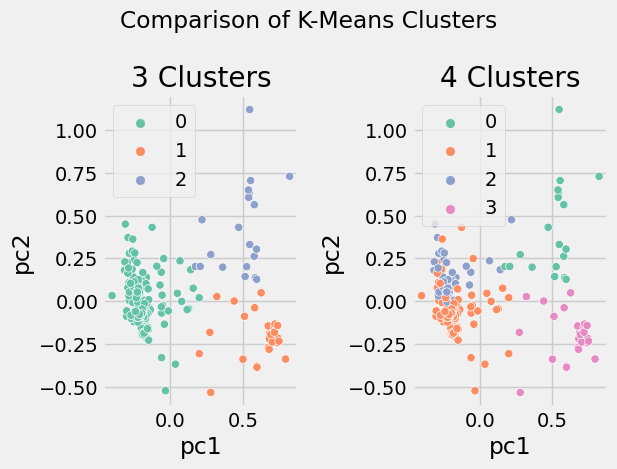

In [21]:
kmeans3 = KMeans(n_clusters=3, **kmeans_kwargs).fit(pca_values)
kmeans4 = KMeans(n_clusters=4, **kmeans_kwargs).fit(pca_values)

fig, ax = plt.subplots(1, 2)
fig.suptitle("Comparison of K-Means Clusters")

ax[0].set_title("3 Clusters")
sns.scatterplot(pca_values["pc1"], pca_values["pc2"], hue=kmeans3.labels_, ax=ax[0], palette=sns.color_palette('Set2', 3))
ax[1].set_title("4 Clusters")
sns.scatterplot(pca_values["pc1"], pca_values["pc2"], hue=kmeans4.labels_, ax=ax[1], palette=sns.color_palette('Set2', 4))

fig.tight_layout()

The data is better grouped into 3 clusters over 4 clusters.

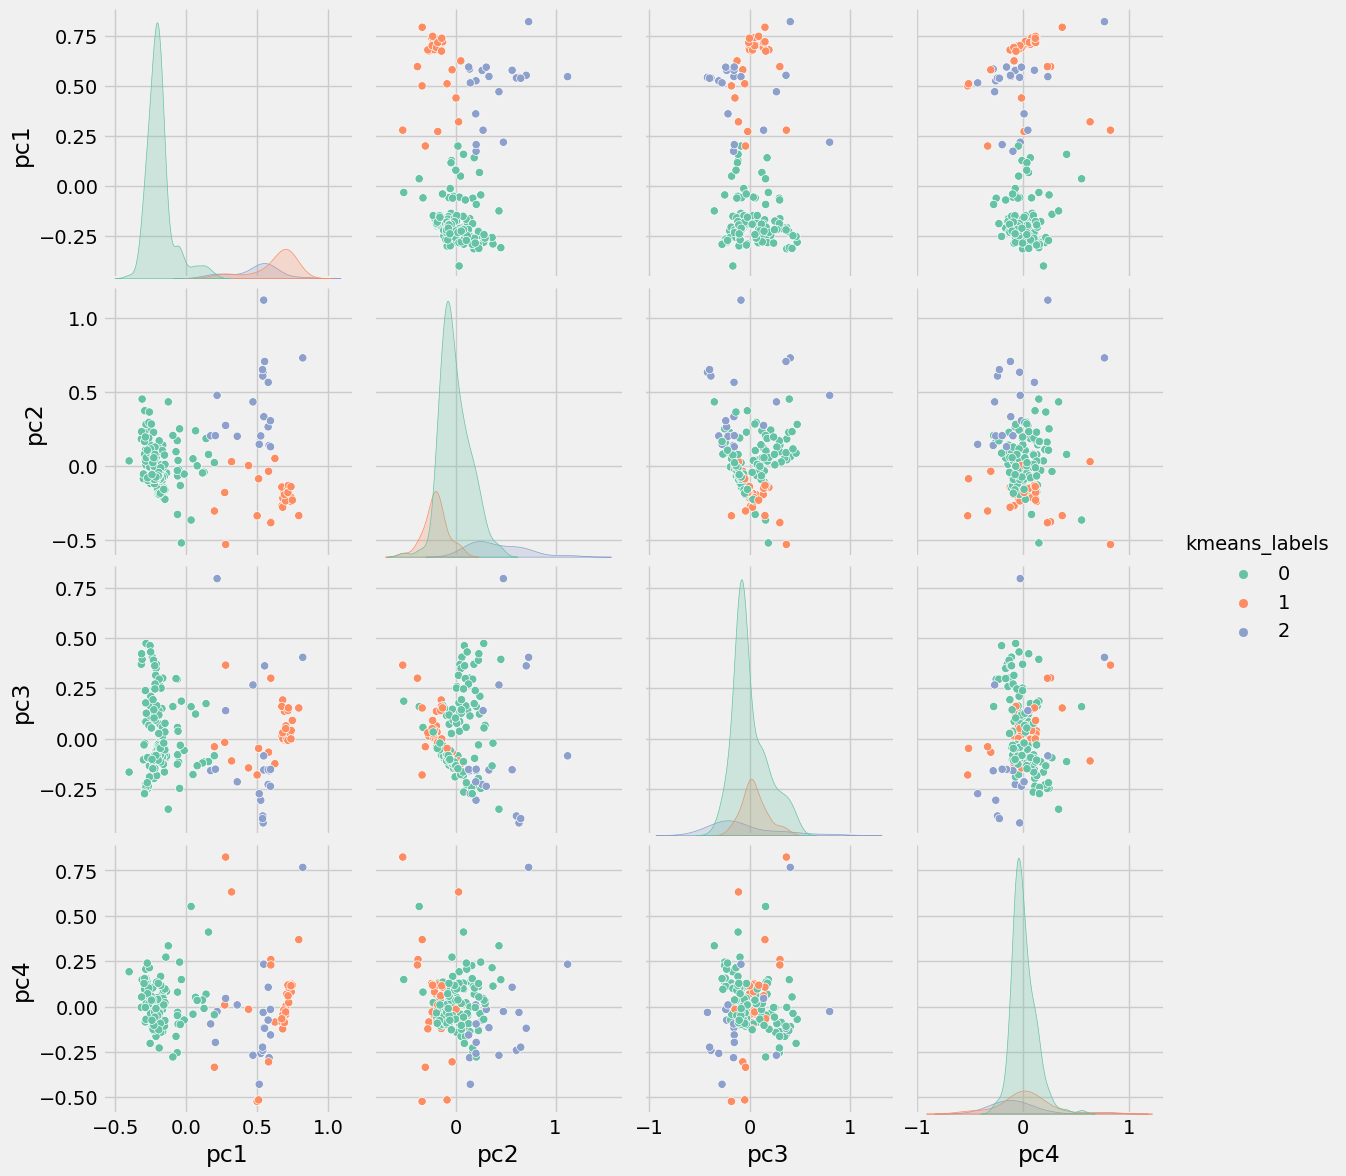

In [22]:
pca_values["kmeans_labels"] = kmeans3.labels_
sns.pairplot(pca_values, hue="kmeans_labels", palette=sns.color_palette('Set2', 3), height=3)

### Summary of K-Means
1. Out of the three groups, group 0 is the most distinguishable.
2. There are many overlap between groups 1 & 2.
3. The distribution of the data is also not spherical, probably making it unsuitable for K-Means.

**Let's try one more clustering algorithm.**

## Clustering with Gaussian Mixture Model

In [23]:
gmm_kwargs = {
    "covariance_type":"full",
    "max_iter": 300,
    "n_init": 10,
    "init_params": "k-means++",
    "random_state": 23,
    }

silhouette_coefficients = []
bic_scores = []
aic_scores = []
pca_values = pca_values[[col for col in pca_values.columns if col != "kmeans_labels"]]  # Removing the K-Means labels
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, **gmm_kwargs)
    gmm_labels = gmm.fit_predict(pca_values)
    score = silhouette_score(pca_values, gmm_labels)
    silhouette_coefficients.append(score)
    bic_scores.append(gmm.bic(pca_values))
    aic_scores.append(gmm.aic(pca_values))

### Identifying number of clusters using silhouette coefficients

Text(0.5, 0, 'No. of Clusters')

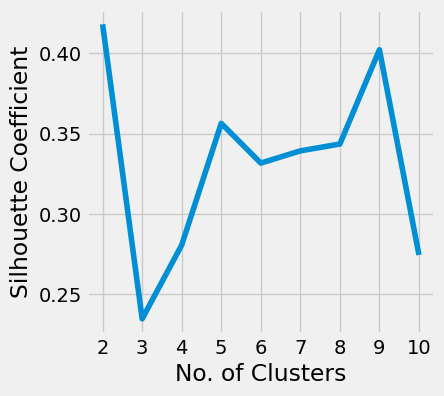

In [24]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(range(2, 11), silhouette_coefficients)
ax.set_xticks(range(2, 11))
ax.set_ylabel("Silhouette Coefficient")
ax.set_xlabel("No. of Clusters")

### Identifying number of clusters using BIC & AIC scores

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

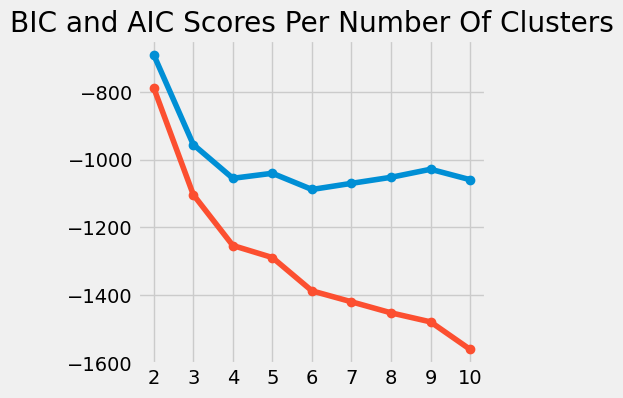

In [25]:
# Plot the BIC and AIC values together
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(range(2, 11), bic_scores, '-o')
ax.plot(range(2, 11), aic_scores, '-o')
ax.set_xticks(range(2, 11))
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

The plots indiciate 4, 5 or 6 clusters in the data.

## Results of Gaussian Mixture Model

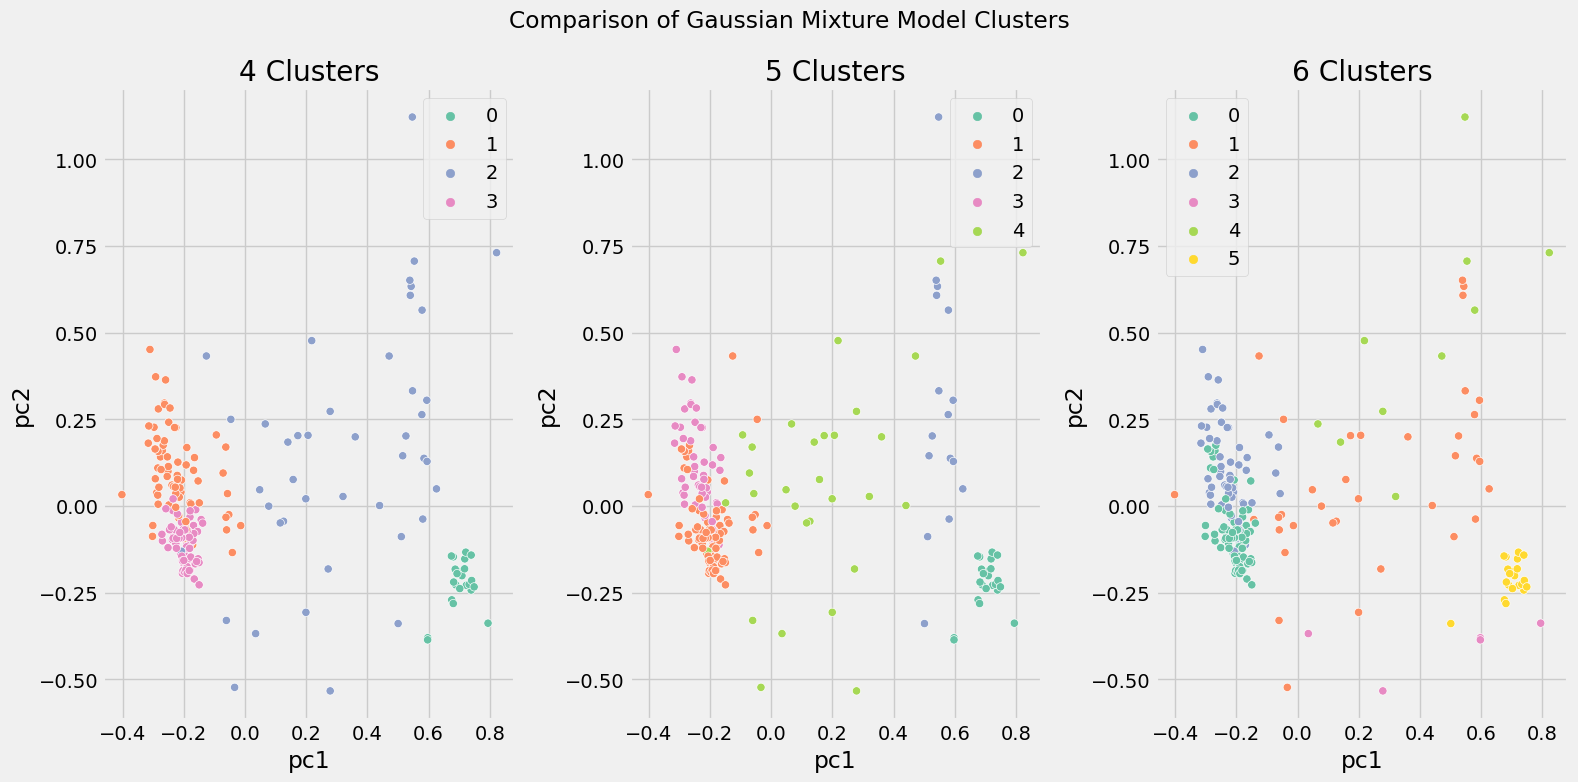

In [26]:
gmm4_labels = GaussianMixture(n_components=4, **gmm_kwargs).fit_predict(pca_values)
gmm5_labels = GaussianMixture(n_components=5, **gmm_kwargs).fit_predict(pca_values)
gmm6_labels = GaussianMixture(n_components=6, **gmm_kwargs).fit_predict(pca_values)

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
fig.suptitle("Comparison of Gaussian Mixture Model Clusters")

ax[0].set_title("4 Clusters")
sns.scatterplot(pca_values["pc1"], pca_values["pc2"], hue=gmm4_labels, ax=ax[0], palette=sns.color_palette('Set2', 4))
ax[1].set_title("5 Clusters")
sns.scatterplot(pca_values["pc1"], pca_values["pc2"], hue=gmm5_labels, ax=ax[1], palette=sns.color_palette('Set2', 5))
ax[2].set_title("6 Clusters")
sns.scatterplot(pca_values["pc1"], pca_values["pc2"], hue=gmm6_labels, ax=ax[2], palette=sns.color_palette('Set2', 6))

fig.tight_layout()

I prefer the results of having 5 clusters as the grouping looks cleaner.

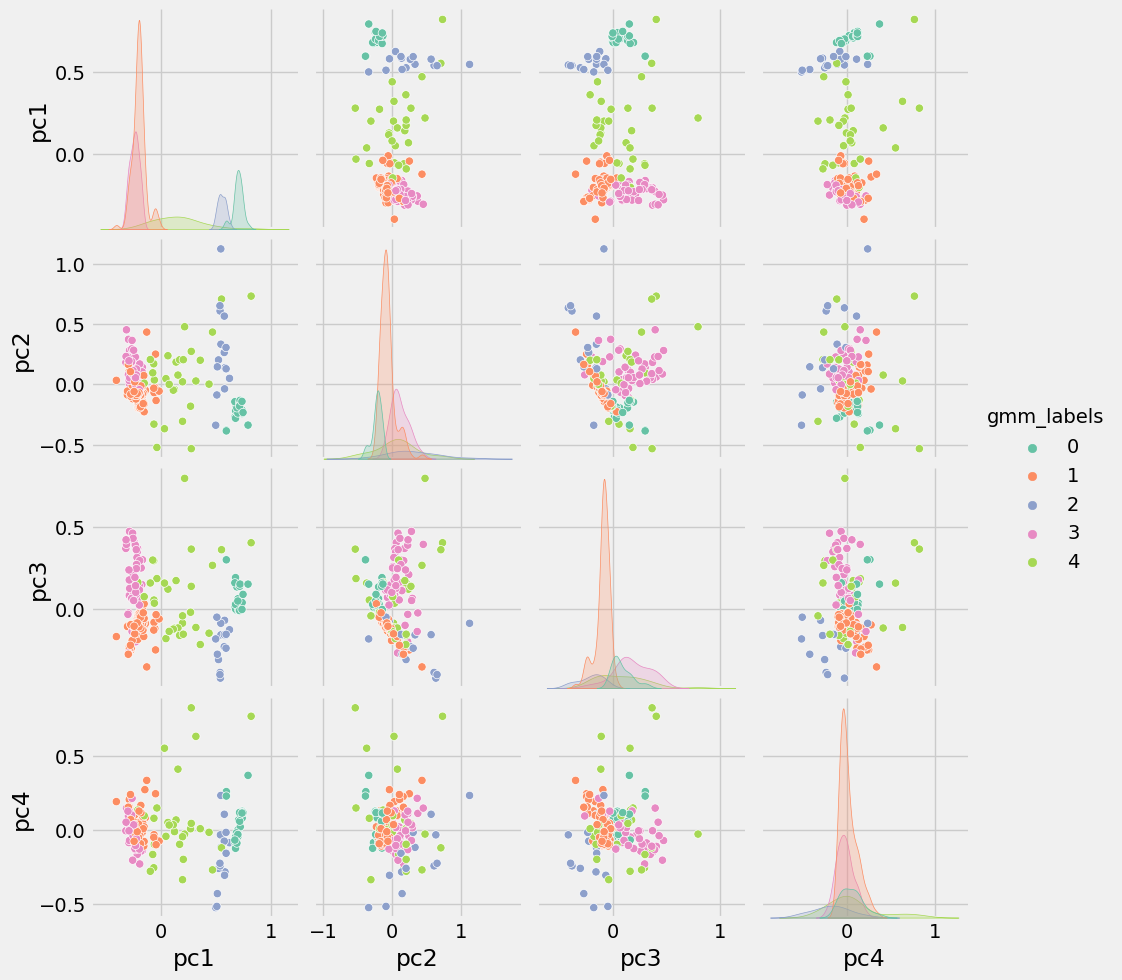

In [27]:
pca_values["gmm_labels"] = gmm5_labels
sns.pairplot(pca_values, hue="gmm_labels", palette=sns.color_palette('Set2', 5))

# Final Results

In [28]:
ingredients["cluster"] = gmm5_labels
ingredients.to_csv("PreScreen_r3\ingredient_with_labels.csv")
ingredients.head()

,a,b,c,d,e,f,g,h,i,cluster
0,1.51735,13.02,3.54,1.69,72.73,0.54,8.44,0.00,0.07,3
1,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28,4
2,1.52300,13.31,3.58,0.82,71.99,0.12,10.17,0.00,0.03,3
3,1.51768,12.56,3.52,1.43,73.15,0.57,8.54,0.00,0.00,1
4,1.51813,13.43,3.98,1.18,72.49,0.58,8.15,0.00,0.00,1
